In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.functional as F
import json
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
torch.cuda.empty_cache()

In [3]:
def conv3x3(in_ch, out_ch, stride=1):
    """3x3 convolution with padding."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)

def conv1x1(in_ch, out_ch, stride=1):
    """1x1 convolution."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride)

class ResidualBlockWithStride(nn.Module):
    """Residual block with a stride on the first convolution.

    Args:
        in_ch (int): number of input channels
        out_ch (int): number of output channels
        stride (int): stride value (default: 2)
    """

    def __init__(self, in_ch, out_ch, stride=2, inplace=False):
        super().__init__()
        self.conv1 = conv3x3(in_ch, out_ch, stride=stride)
        self.leaky_relu = nn.LeakyReLU(inplace=inplace)
        self.conv2 = conv3x3(out_ch, out_ch)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=inplace)
        if stride != 1:
            self.downsample = conv1x1(in_ch, out_ch, stride=stride)
        else:
            self.downsample = None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.leaky_relu(out)
        out = self.conv2(out)
        out = self.leaky_relu2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity
        return out

class IntraPredictorModel(nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.in_ch = 128
        self.h_ch1 = 192
        self.h_ch2 = 256

        self.global_h = 8
        self.global_w = 8

        self.inner_dim1 = 512
        self.inner_dim2 = 256
    
        self.res_block1 = ResidualBlockWithStride(self.in_ch, self.h_ch1, stride=2)
        self.res_block2 = ResidualBlockWithStride(self.h_ch1, self.h_ch2, stride=2)
        self.global_pooling = nn.AdaptiveAvgPool2d((self.global_w, self.global_h))
        self.linear1 = nn.Linear(self.global_h * self.global_w * self.h_ch2, self.inner_dim1)
        self.linear2 = nn.Linear(self.inner_dim1, self.inner_dim2)
        self.leaky_relu = nn.LeakyReLU(inplace=inplace)
        self.linear_out = nn.Linear(self.inner_dim2, 1)
        self.softmax = nn.Sigmoid()

    def forward(self, x):
        x = self.res_block1(x)
        x = self.res_block2(x)

        x = self.global_pooling(x)

        x = x.view(x.size(0), -1)

        x = self.linear1(x)
        x = self.leaky_relu(x)
        x = self.linear2(x)
        x = self.leaky_relu(x)
        # x, _ = self.lstm(x)
        x = self.linear_out(x)
        logits = self.softmax(x)

        return x, logits

In [4]:
with open("../media/syntetic-low/long_large_predictor_dataset_0/reference_points.json", "r") as f:
    intra_ref_points = json.load(f)

In [5]:
def enrich_ref_points(ref_points, distance=64):
    enriched = []
    all_points = set(ref_points)
    for idx in range(1, len(ref_points)):
        prev = ref_points[idx - 1]
        curr = ref_points[idx]
        all_points.update(np.arange(prev, curr, distance, dtype=int))
    
    return sorted([int(p) for p in all_points])

In [6]:
all_ref_points = enrich_ref_points(intra_ref_points)

In [7]:
all_ref_points = intra_ref_points

```python
frames_data = {
    "intra_frames": intra_ref_points,
    "refresh_frames": all_ref_points
}

with open("../media/syntetic/predictor_dataset_0/frames.json", "w") as f:
    json.dump(frames_data, f)
```

### Train loop with loaded inputs. 

Epochs should consist of going through the whole set of batches.
Batch is consisting of frames (contexts of those frames) within the range of the two neighboring reference points (`all_ref_points`).
Loss function is cross entropy between frame types (0 - non-reference, 1 - reference). Cross entropy should be weighted, so that the punishment for not guessing the reference frame is higher.

In [4]:
loaded = torch.load("../output/window_large_predictor_contexts_low/contexts.pth")
# loaded = torch.load("../output/predictor_contexts/contexts.pth")

In [5]:
loaded = torch.cat([torch.zeros_like(loaded[0]).unsqueeze(0), loaded], dim=0).to(torch.float32)

In [6]:
# ref_frame_weight = 3

dist_alpha = 1
dist_beta = 1.2
non_ref_distribution = torch.distributions.Beta(dist_alpha, dist_beta)

def criterion_for_batch(batch_size, device='cpu'):
  weights = (torch.exp(non_ref_distribution.log_prob(torch.linspace(0, 1, batch_size - 1))) / (dist_alpha * 2)) + 0.5
  
  # Zero weight for random samples

  # downsample_rate = 0.7
  # weights = torch.random.shuffle(
  #   torch.cat([
  #     torch.ones()
  #   ])
  # )

  weights = torch.cat([weights, torch.tensor([batch_size / 4])]) / batch_size

  # Punish FP for 0s and FN for 1s
  # pos_weight = torch.ones_like(weights) * 5
  return nn.BCEWithLogitsLoss(weight=weights).to(device)

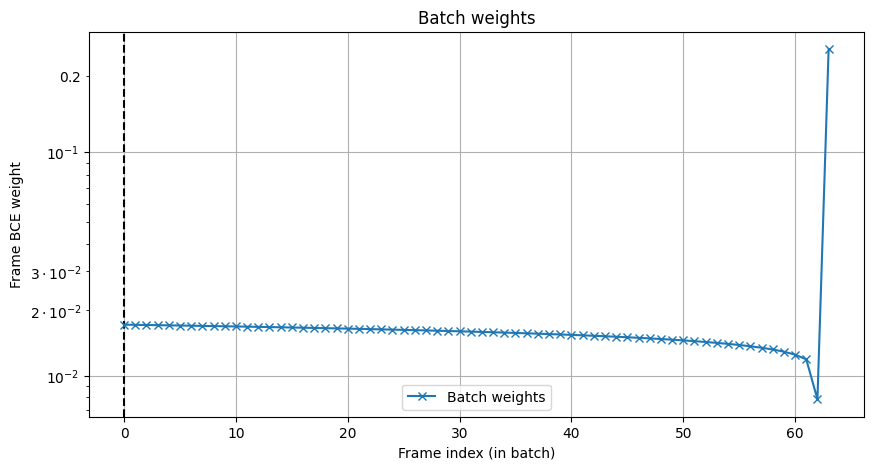

In [7]:
batch_size = 64
weights = (torch.exp(non_ref_distribution.log_prob(torch.linspace(0, 1, batch_size - 1))) / (dist_alpha * 2)) + 0.5
weights = torch.cat([weights, torch.tensor([batch_size / 4])]) / batch_size

plt.figure(figsize=(10, 5))

plt.yscale("logit")
plt.title("Batch weights")
plt.grid()
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')

plt.plot(weights.numpy(), label="Batch weights", marker='x')
plt.xlabel("Frame index (in batch)")
plt.ylabel("Frame BCE weight")
plt.legend()
plt.show()

In [8]:
with open("../output/window_large_predictor_contexts_low/result.json", "r") as res_f:
  result_json = json.load(res_f)

In [9]:
frame_types = np.array(result_json['window_large_predictor_contexts_low']['long_large_predictor_dataset_0']['000']['frame_type'])

all_ref_points = [1] + list(np.where(frame_types > 1)[0] + 1)

In [10]:
ref_ranges = []

start_rng = None
stop_rng = None
for idx in range(len(frame_types)):
  if frame_types[idx] == 0 or frame_types[idx] == 2:
    start_rng = idx
  elif frame_types[idx] == 3:
    stop_rng = idx  
    if start_rng is not None and stop_rng is not None:
      ref_ranges.append([start_rng + 1, stop_rng + 1])
      start_rng = idx + 1
      stop_rng = None

print(len(ref_ranges))

340


In [11]:
all_ref_points = ref_ranges

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
train_proc = int(len(all_ref_points) * 0.8)
test_proc = len(all_ref_points) - train_proc

In [14]:
loaded.size()

torch.Size([40000, 128, 23, 40])

In [15]:
train_idx, test_idx = all_ref_points[:train_proc], all_ref_points[train_proc:]

In [37]:
def train(model, epochs, device, ref_points, optimizer):
    losses = []

    for epoch in trange(epochs):
        epoch_loss = []
        range_mode = True if type(ref_points[0]) is list else False

        train_indicies = list(range(0 if range_mode else 1, len(ref_points)))
        np.random.shuffle(train_indicies)
        for idx in train_indicies:
            if range_mode:
                start_frame = max(ref_points[idx][0] - 1, 1)
                end_frame = ref_points[idx][1] - 1
            else:
                start_frame = max(ref_points[idx - 1] - 1, 1) # Skip first intra frame from sequence
                end_frame = ref_points[idx] - 1

            batch_size = end_frame - start_frame + 1
            criterion = criterion_for_batch(batch_size, device)

            batch = loaded[start_frame:end_frame + 1]
            batch = batch.to(device)

            # fst_frame = batch[0].unsqueeze(0)
            # batch = batch[1:]

            optimizer.zero_grad()
            output, _ = model(batch)
            true_labels = torch.cat([torch.zeros(batch_size - 1), torch.ones(1)]).to(torch.float32).to(device)

            # print("{} {}".format(output.squeeze(1).size(), true_labels.size()))
            # print("{}\n{}".format(output.squeeze(1), true_labels))

            loss = criterion(output.squeeze(1), true_labels)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        
        losses.append(np.mean(epoch_loss))
        epoch_loss = []

        if epoch % 5 == 0:

            clear_output(wait=True)

            plt.figure(figsize=(15,15))

            total_rows = 2 if range_mode else 3

            plt.subplot(total_rows, 1, 1)
            plt.plot(losses, label="Weighted BCELoss", linewidth=0.8, marker="x")
            plt.grid(True)
            plt.legend()
            plt.axhline(0, color="k", linestyle="--")
            plt.axvline(0, color="k", linestyle="--")

            plt.subplot(total_rows, 1, 2)

            # with torch.no_grad():
            #     _, result = model(loaded[train_idx[0]], loaded[train_idx[0] + 1: train_idx[10]])
            #     result = result.detach().cpu()
            #     # plt.figure(figsize=(15,5))
            #     plt.grid(True)
            #     plt.scatter(torch.arange(train_idx[0] + 1, train_idx[10]), result, alpha=result.squeeze(1) / 10 * 8 + 0.2)
            #     for idx in train_idx[0:10]:
            #         plt.axvline(idx, c = 'r', alpha = 0.3)

            # plt.subplot(3, 1, 3)

            # with torch.no_grad():
            #     _, result = model(loaded[train_idx[-1]], loaded[train_idx[-1] + 1:])
            #     result = result.detach().cpu()
            #     # plt.figure(figsize=(15,5))
            #     plt.grid(True)
            #     plt.scatter(torch.arange(train_idx[-1] + 1, loaded.size(0)), result, alpha=result.squeeze(1) / 10 * 8 + 0.2)
            #     for idx in test_idx:
            #         plt.axvline(idx, c = 'r', alpha = 0.3)

            with torch.no_grad():
                start = train_idx[0][0] if range_mode else train_idx[0]
                end = train_idx[10][1] if range_mode else train_idx[10]
                data = loaded[start: end]
                data = data.to(device)
                _, result = model(data)
                result = result.detach().cpu()
                del(data)
                # plt.figure(figsize=(15,5))
                plt.grid(True)
                plt.scatter(torch.arange(start, end), result, alpha=result.squeeze(1) / 10 * 8 + 0.2)
                for idx in train_idx[0:10]:
                    plt.axvline(idx[1] if range_mode else idx, c = 'r', alpha = 0.3)


            if not range_mode:
                plt.subplot(total_rows, 1, 3)
                with torch.no_grad():
                    data = loaded[train_idx[-1]:]
                    data = data.to(device)
                    _, result = model(data)
                    result = result.detach().cpu()
                    del(data)
                    # plt.figure(figsize=(15,5))
                    plt.grid(True)
                    plt.scatter(torch.arange(train_idx[-1], loaded.size(0)), result, alpha=result.squeeze(1) / 10 * 8 + 0.2)
                    for idx in test_idx:
                        plt.axvline(idx, c = 'r', alpha = 0.3)

            plt.show()


            print("Epoch: {} Loss: {}".format(epoch, losses[-1]))
    
    return losses

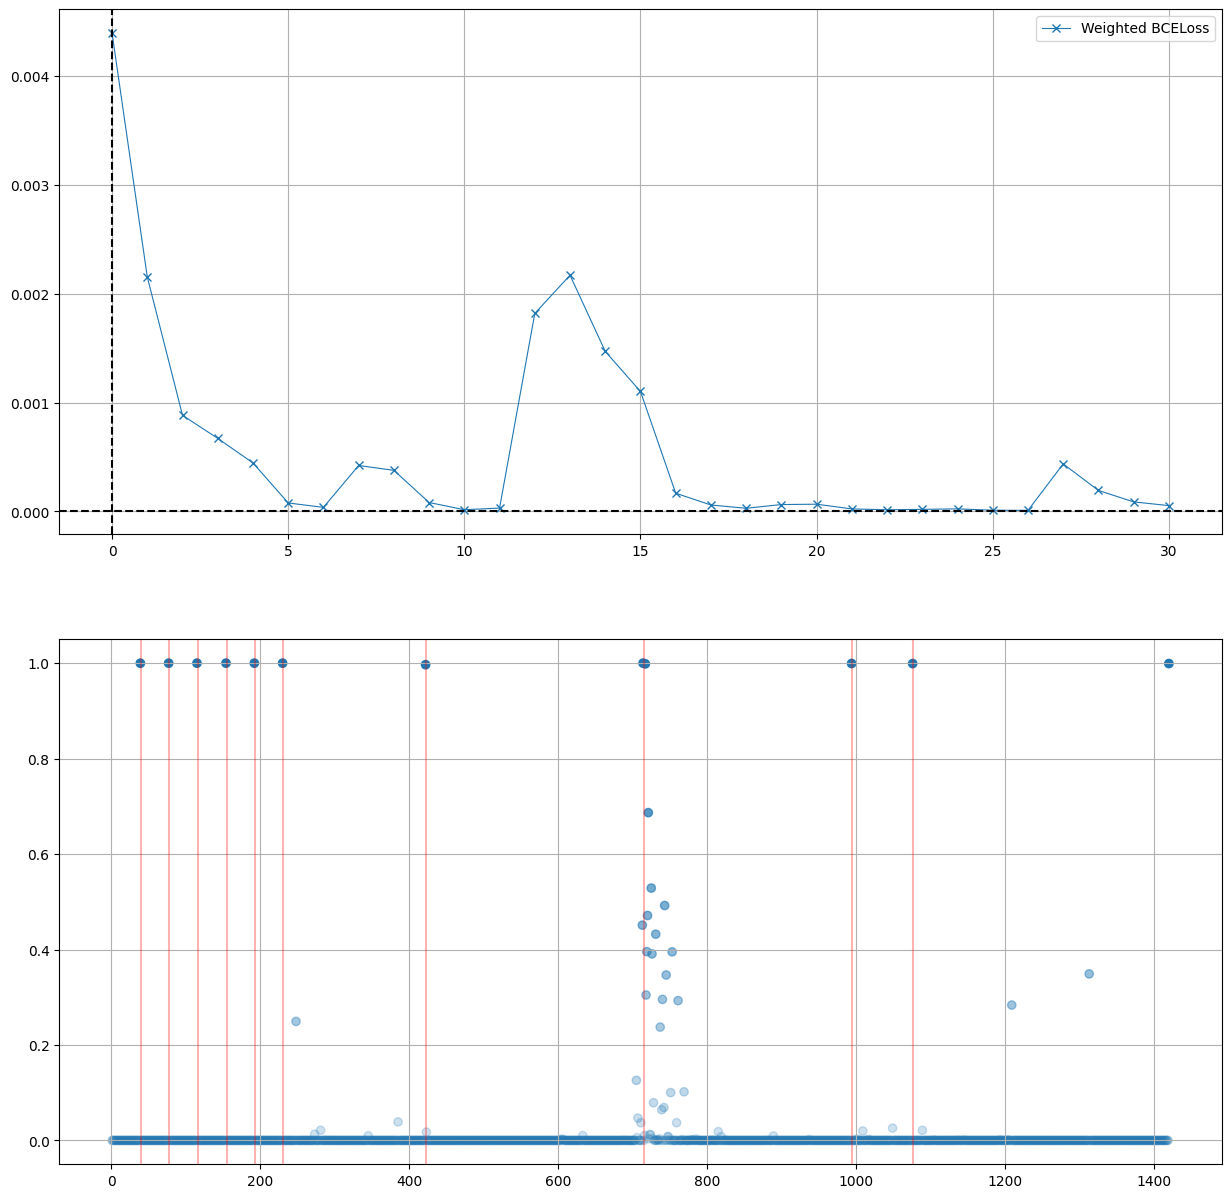

Epoch: 30 Loss: 5.384672412651484e-05


KeyboardInterrupt: 

In [38]:
model = IntraPredictorModel().to(torch.float32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

l = train(model, 100, device, train_idx, optimizer)

In [16]:
from sklearn.metrics import f1_score, accuracy_score

In [17]:
range_mode = True if type(train_idx[0]) is list else False

In [63]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [66]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 29           |        cudaMalloc retries: 30        |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  20298 MiB |  20298 MiB |   9451 GiB |   9431 GiB |
|       from large pool |  20291 MiB |  20291 MiB |   9394 GiB |   9374 GiB |
|       from small pool |      6 MiB |     15 MiB |     57 GiB |     57 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  20298 MiB |  20298 MiB |   9451 GiB |   9431 GiB |
|       from large pool |  20291 MiB |  20291 MiB |   9394 GiB |

In [20]:
last_train = train_idx[-1][1] if range_mode else train_idx[-1]

_, eval_result = model(loaded[last_train:].to(device))
eval_result = eval_result.detach().cpu().squeeze(1)

target = torch.zeros_like(eval_result)
target[(torch.tensor(test_idx)[:, 1] if range_mode else torch.tensor(test_idx)) - last_train - 1 ] = 1

In [22]:
currect_switches = (eval_result > 0.5)[torch.tensor(test_idx) - 1 - last_train].sum() / len(test_idx)

print(f"Proc of correct switches: {currect_switches:.2f}")

Proc of correct switches: 0.97


In [23]:
accuracy_score(target, eval_result > 0.5), f1_score(target, eval_result > 0.5)

(0.9976369812435386, 0.8873239436619719)

In [25]:
test_low = torch.load("../output/predictor_contexts_low/contexts.pth")
test_low = torch.cat([torch.zeros_like(test_low[0]).unsqueeze(0), test_low], dim=0).to(torch.float32).to(device)

In [26]:
with open("../media/syntetic-low/predictor_dataset_0/reference_points.json", "r") as f:
    test_ref_points = json.load(f)

# test_ref_points = enrich_ref_points(test_ref_points)

In [27]:
_, test_eval_result = model(test_low)
test_eval_result = test_eval_result.detach().cpu().squeeze(1)

test_target = torch.zeros_like(test_eval_result)
test_target[torch.tensor(test_ref_points) - 1] = 1

In [28]:
test_currect_switches = (test_eval_result > 0.8)[torch.tensor(test_ref_points) - 1].sum() / len(test_ref_points)

print(f"Proc of correct TEST switches: {test_currect_switches:.2f}")

Proc of correct TEST switches: 0.89


In [24]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [25]:
train_measure = perf_measure(target, (eval_result > 0.5))

print("Train results: TP: {} FP: {} TN: {} FN: {}. Actual positives: {}".format(*train_measure, target.sum()))

Train results: TP: 63 FP: 11 TN: 6692 FN: 5. Actual positives: 68.0


In [31]:
test_measure = perf_measure(test_target, (test_eval_result > 0.5))

print("Test results: TP: {} FP: {} TN: {} FN: {}. Actual positives: {}".format(*test_measure, test_target.sum()))

Test results: TP: 17 FP: 30 TN: 2952 FN: 1. Actual positives: 18.0


In [67]:
# save model
model = model.to(torch.device('cpu'))
torch.save(model.state_dict(), "../checkpoints/intra_model_2/test.pth")

In [19]:
# load_model

model = IntraPredictorModel()
model.load_state_dict(torch.load("../checkpoints/intra_model_2/test.pth"))
model = model.to(device)

In [ ]:
x = list(range(0,10))

In [ ]:
np.percentile(x, 20)

In [ ]:
np.percentile(x[12:14], 50)